## Домашняя работа 4. Крупица Полина БЭК202

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data.adult.csv")
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [3]:
data = data.replace('?', np.nan)
pd.isna(data).sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [4]:
data.dropna(inplace = True)

In [5]:
pd.isna(data).sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [6]:
y = data['>50K,<=50K']
data.drop('>50K,<=50K', axis =1, inplace = True)

In [7]:
y = y.replace('>50K', 1)
y = y.replace('<=50K', 0)

In [8]:
y

0        0
1        0
2        0
3        0
4        1
        ..
16275    0
16276    1
16277    0
16278    0
16279    1
Name: >50K,<=50K, Length: 15347, dtype: int64

In [9]:
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
dtype: object

In [10]:
data_int = data[['age','fnlwgt', 'education-num', 'capital-gain','capital-loss', 'hours-per-week']]

In [11]:
data_int

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

## kNN

In [19]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [114]:
kf = KFold(n_splits=5, shuffle=True)
knn = KNeighborsClassifier()
k = np.arange(1, 21)
param_grid = {'n_neighbors': k}

grid = GridSearchCV(knn, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int, y)
best_kNN = grid.best_score_
grid.best_params_

{'n_neighbors': 4}

In [115]:
print('Лучшее значение гиперпараметра:', grid.best_params_)
print('Лучшее знвчение ROC_AUC:', grid.best_score_)

Лучшее значение гиперпараметра: {'n_neighbors': 4}
Лучшее знвчение ROC_AUC: 0.6440618501807157


In [116]:
mean = grid.cv_results_["mean_test_score"]
std = grid.cv_results_["std_test_score"]

Text(0, 0.5, 'mean roc-auc score')

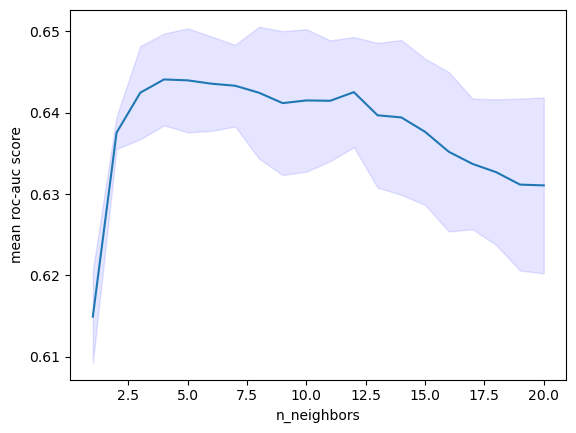

In [117]:


#some example data
x_plot = [i for i in range(1, 21)]
y_plot = mean
#some confidence interval
ci = std

fig, ax = plt.subplots()
ax.plot(x_plot,y_plot)
ax.fill_between(x_plot, (y_plot-ci), (y_plot+ci), color='b', alpha=.1)
plt.xlabel('n_neighbors')
plt.ylabel('mean roc-auc score')

## Decision Tree

In [90]:
tree = DecisionTreeClassifier()
depth = np.arange(1, 21)
param_grid = dict(max_depth=depth)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int, y)
best_d_t = grid.best_score_
grid.best_params_

{'max_depth': 7}

In [91]:
print('Лучшее значение гиперпараметра:', grid.best_params_)
print('Лучшее знвчение ROC_AUC:', grid.best_score_)

Лучшее значение гиперпараметра: {'max_depth': 7}
Лучшее знвчение ROC_AUC: 0.8405415994822238


In [92]:
mean = grid.cv_results_["mean_test_score"]
std = grid.cv_results_["std_test_score"]

Text(0, 0.5, 'mean roc-auc score')

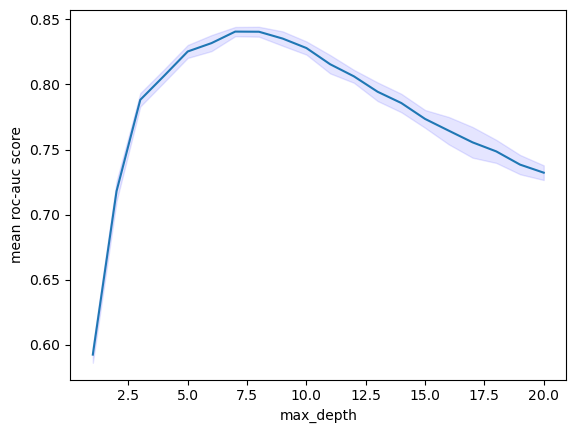

In [93]:


#some example data
x_plot = [i for i in range(1, 21)]
y_plot = mean
#some confidence interval
ci = std

fig, ax = plt.subplots()
ax.plot(x_plot,y_plot)
ax.fill_between(x_plot, (y_plot-ci), (y_plot+ci), color='b', alpha=.1)
plt.xlabel('max_depth')
plt.ylabel('mean roc-auc score')

## SGD Linear Classifier

In [118]:
sgd = SGDClassifier() 

param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(sgd, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int, y)
best_sgd = grid.best_score_
grid.best_params_

/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` wh

{'loss': 'modified_huber'}

In [119]:
print('Лучшее значение гиперпараметра:', grid.best_params_)
print('Лучшее знвчение ROC_AUC:', grid.best_score_)

Лучшее значение гиперпараметра: {'loss': 'modified_huber'}
Лучшее знвчение ROC_AUC: 0.6238106749945136


In [120]:
mean = grid.cv_results_["mean_test_score"]
std = grid.cv_results_["std_test_score"]

Text(0, 0.5, 'mean roc-auc score')

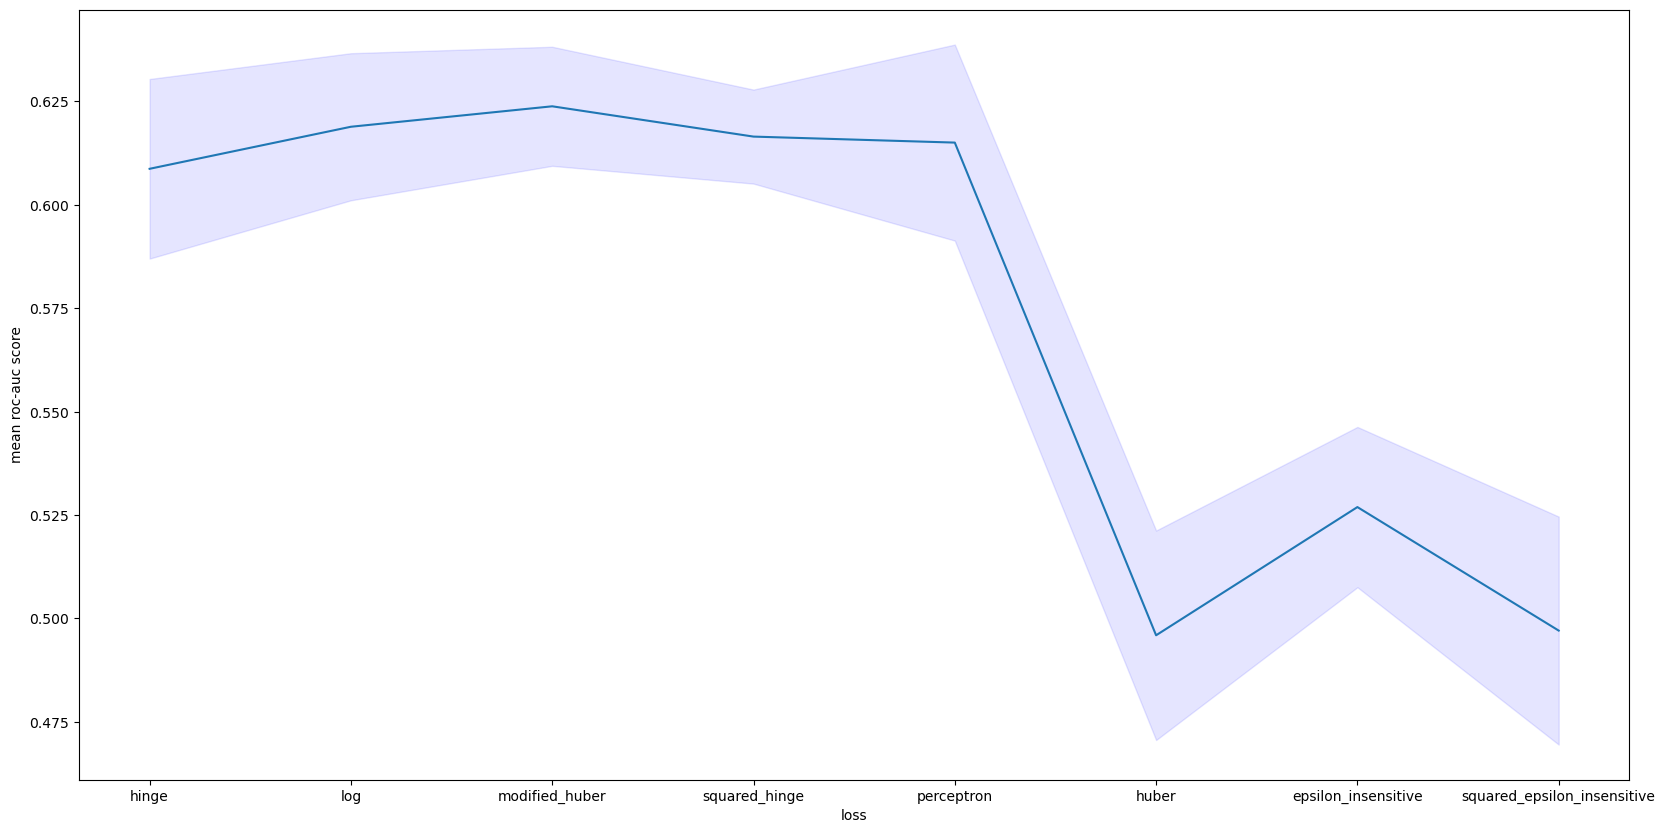

In [121]:

fig, ax = plt.subplots(figsize=(20,10))
#some example data
x_plot = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
y_plot = mean
#some confidence interval
ci = std

ax.plot(x_plot,y_plot)
ax.fill_between(x_plot, (y_plot-ci), (y_plot+ci), color='b', alpha=.1)
plt.xlabel('loss')
plt.ylabel('mean roc-auc score')

По графику для kNN можно сказать, что при значениях больше около 10, качество начинает снижаться. Промежуток максимального качества - от 4 до 12. При этом на этой модели можно заметить довольно большой разброс дисперсий - это говорит о сравнительной неуверенности подбора таких гиперпараметров. 

График модели Decision Tree вообще можно сказать показательный. Не в смысле показательной функции, а в смысле очень красивый. Тут явно видно максимум при значении гиперпараметра 8. Возможно стоило сделать шаг между гиперпараметрами меньше, но думаю, что сильно большой разницы не будет. Доверительные интервалы сравнительно небольшие - что также не может не радовать.

Ну и для последней модели можно заметить, что первые 5 функций лосса дают примерно одинаково высокие значения, остальные - совсем маленькие. При этом все-таки modified huber дает хоть и незначительно, но более высокое качество.

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
estim

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

In [29]:
rf = RandomForestClassifier()
estim = np.arange(1, 50, 2)
param_grid = dict(n_estimators = estim)

grid = GridSearchCV(rf, param_grid, cv=kf, scoring='roc_auc')
  
grid.fit(data_int, y)
best_rfc = grid.best_params_
best_rfc

{'n_estimators': 45}

In [30]:
print('Лучшее значение гиперпараметра:', grid.best_params_)
print('Лучшее знвчение ROC_AUC:', grid.best_score_)

Лучшее значение гиперпараметра: {'n_estimators': 45}
Лучшее знвчение ROC_AUC: 0.8156898028820434


In [33]:
mean = grid.cv_results_["mean_test_score"]
std = grid.cv_results_["std_test_score"]

Text(0, 0.5, 'mean roc-auc score')

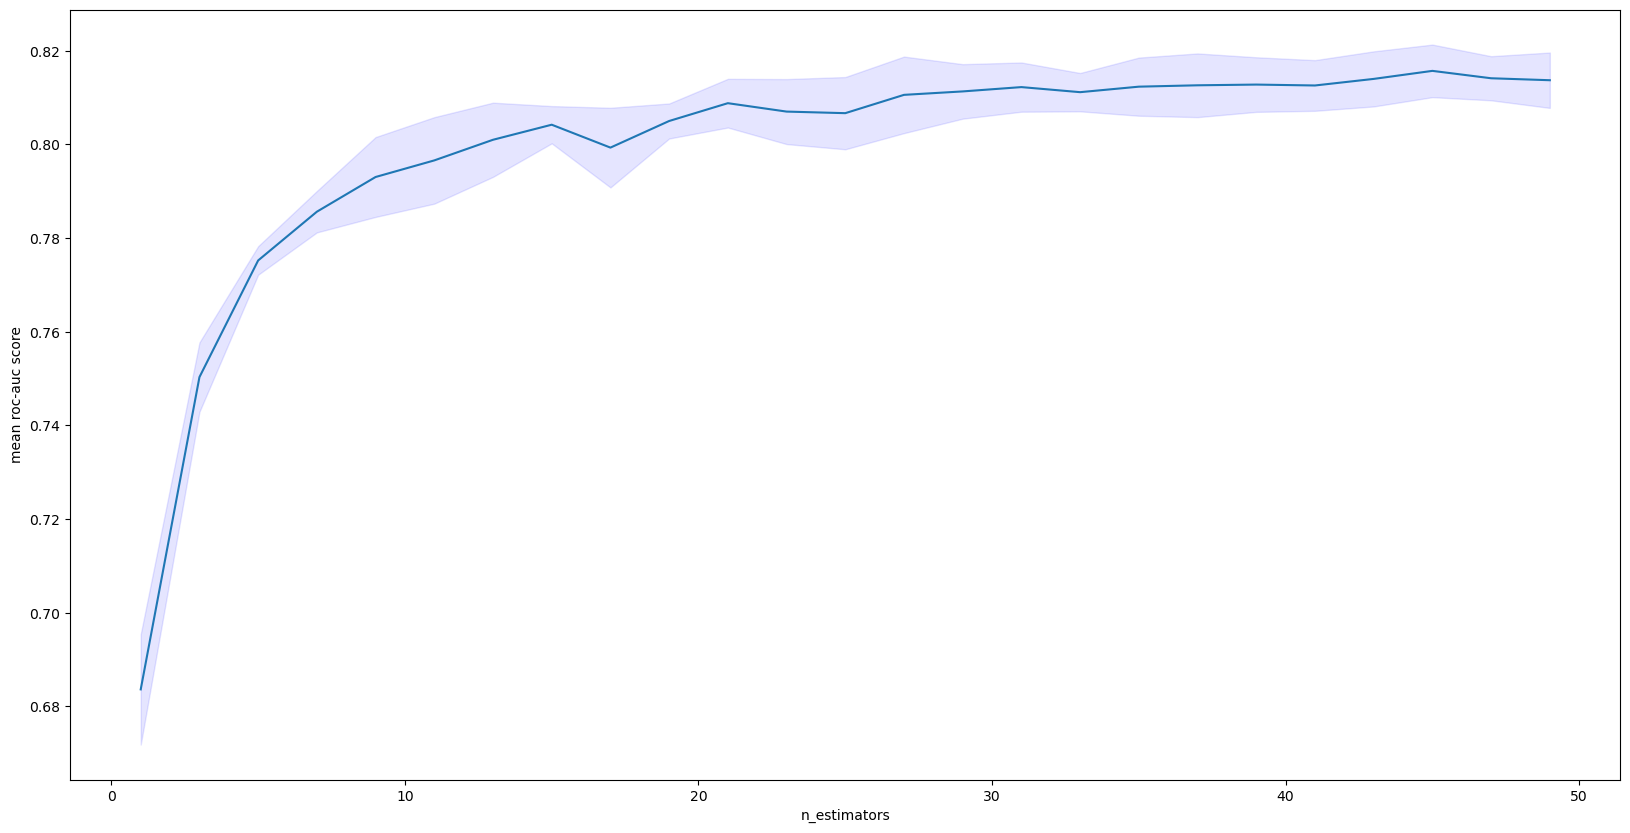

In [35]:

fig, ax = plt.subplots(figsize=(20,10))
#some example data
x_plot = estim
y_plot = mean
#some confidence interval
ci = std

ax.plot(x_plot,y_plot)
ax.fill_between(x_plot, (y_plot-ci), (y_plot+ci), color='b', alpha=.1)
plt.xlabel('n_estimators')
plt.ylabel('mean roc-auc score')

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_int, y, test_size=0.3, random_state=0)

In [46]:
losses = []
for i in tqdm(range(1,400, 10)):
    gb = GradientBoostingClassifier(n_estimators = i)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    curr_loss = log_loss(y_test, y_pred)
    losses.append(curr_loss)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [04:01<00:00,  6.03s/it]


In [47]:
np.argmin(losses)

36

In [48]:
min(losses)

6.105113929101276

Text(0, 0.5, 'loss')

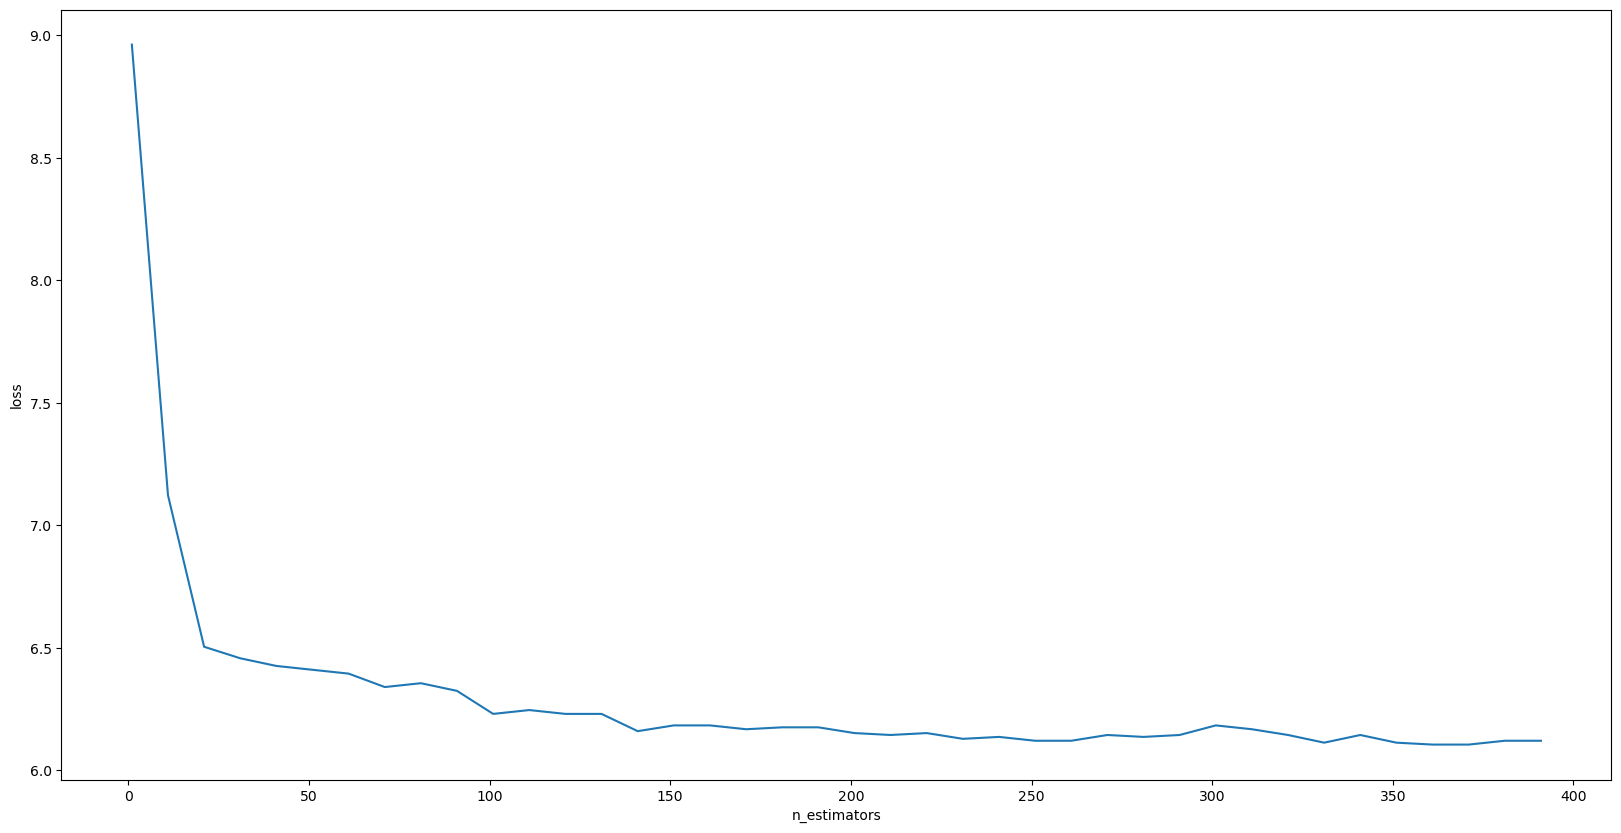

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
#some example data
x_plot = range(1,400, 10)
y_plot = losses

ax.plot(x_plot,y_plot)
plt.xlabel('n_estimators')
plt.ylabel('loss')

In [49]:
losses_2 = []
for i in tqdm(range(1,50)):
    gb = GradientBoostingClassifier(n_estimators = i)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    curr_loss = log_loss(y_test, y_pred)
    losses_2.append(curr_loss)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:38<00:00,  1.27it/s]


In [52]:
np.argmin(losses_2)

48

In [53]:
min(losses_2)

6.379061348996846

Text(0, 0.5, 'loss')

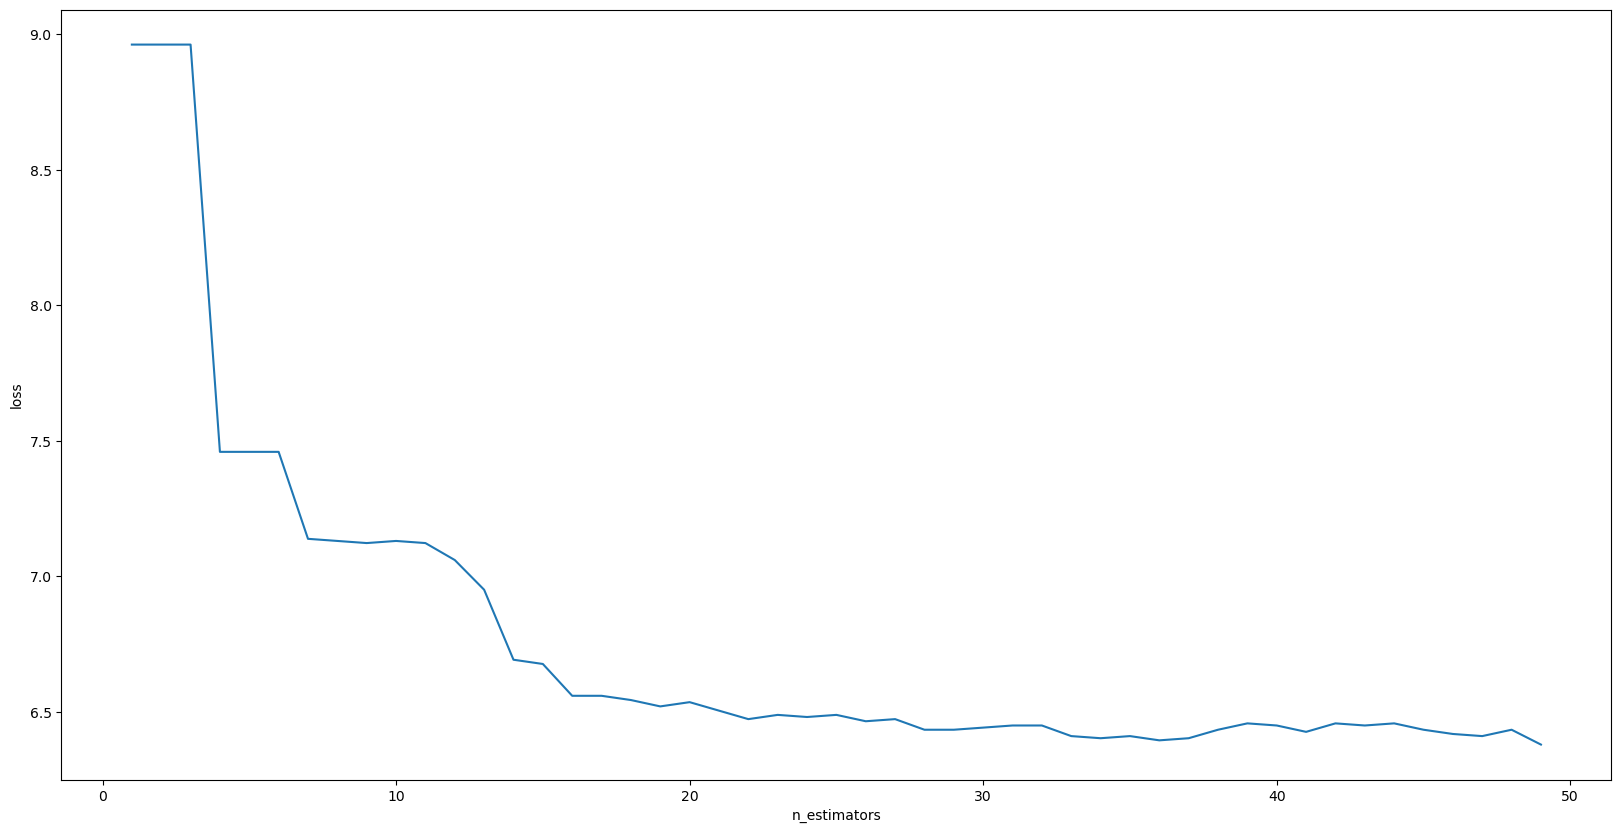

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
#some example data
x_plot = range(1,50)
y_plot = losses_2

ax.plot(x_plot,y_plot)
plt.xlabel('n_estimators')
plt.ylabel('loss')

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
gb_best_score = np.mean(cross_val_score(GradientBoostingClassifier(n_estimators=36), data_int , y, scoring='roc_auc', cv=kf))
gb_best_score

0.8534425365946223

In [57]:
gb_best_score = np.mean(cross_val_score(GradientBoostingClassifier(n_estimators=48), data_int , y, scoring='roc_auc', cv=kf))
gb_best_score

0.8562585751365692

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

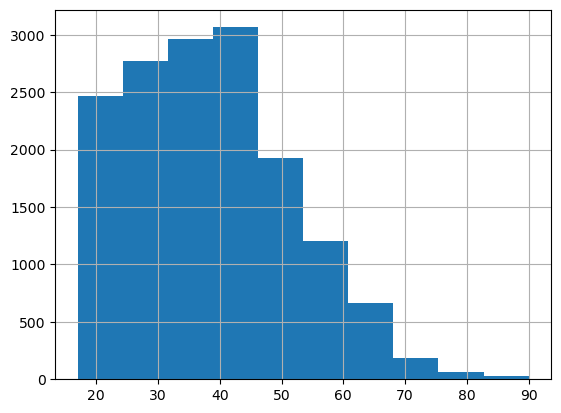

In [14]:
h = data['age'].hist()
fig = h.get_figure()

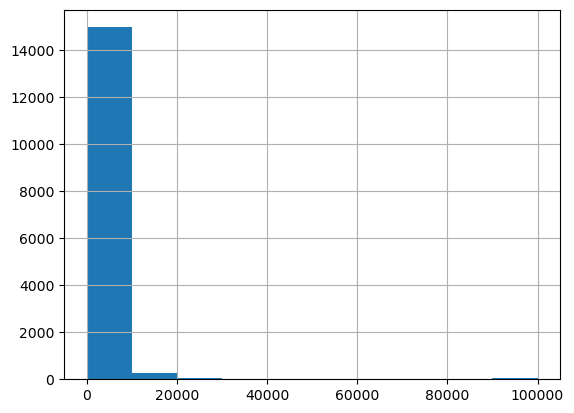

In [15]:
h = data['capital-gain'].hist()
fig = h.get_figure()

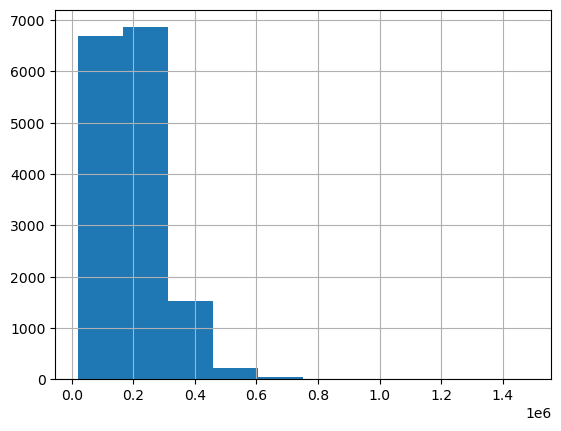

In [16]:
h = data['fnlwgt'].hist()
fig = h.get_figure()

 Можно заметить, что у перменных довольно сильные разбросы значений, что может повлиять на kNN, потому что. kNN считает расстояние между соседними объектами, а если особенно возводить в квадрат такие значения, то они окажутся ну с слишком сильным разбросом.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [17]:
import pandas as pd
from sklearn import preprocessing
x = data_int.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_int_scaled = pd.DataFrame(x_scaled)

In [18]:
data_int_scaled

,0,1,2,3,4,5
0,0.232877,0.181207,0.533333,0.005940,0.000000,0.602041
1,0.315068,0.116683,0.600000,0.000000,0.000000,0.397959
2,0.260274,0.108200,0.800000,0.000000,0.000000,0.397959
3,0.068493,0.112907,0.600000,0.000000,0.000000,0.295918
4,0.410959,0.088984,0.800000,0.150242,0.000000,0.397959
...,...,...,...,...,...,...
15342,0.109589,0.338074,0.800000,0.000000,0.000000,0.397959
15343,0.205479,0.128542,0.800000,0.150242,0.000000,0.448980
15344,0.136986,0.058110,0.800000,0.000000,0.000000,0.397959
15345,0.575342,0.170191,0.533333,0.000000,0.000000,0.397959


In [123]:
kf = KFold(n_splits=5, shuffle=True)
knn = KNeighborsClassifier()
k = np.arange(1, 21)
param_grid = {'n_neighbors': k}
grid = GridSearchCV(knn, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int_scaled, y)
best_kNN_2 = grid.best_score_
print('было:', best_kNN)
print('стало:', best_kNN_2)

было: 0.6440618501807157
стало: 0.8197973294365906


In [124]:
tree = DecisionTreeClassifier()
depth = np.arange(1, 21)
param_grid = dict(max_depth=depth)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int_scaled, y)
best_d_t_2 = grid.best_score_
print('было:', best_d_t)
print('стало:', best_d_t_2)

было: 0.8405415994822238
стало: 0.8380995977711707


In [125]:
sgd = SGDClassifier() 

param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(sgd, param_grid, cv=kf, scoring='roc_auc')
grid.fit(data_int_scaled, y)
best_sgd_2 = grid.best_score_
print('было:', best_sgd)
print('стало:', best_sgd_2)

/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/polinakrupica/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` wh

было: 0.6238106749945136
стало: 0.8249393083633645


Изменилось ли качество у некоторых алгоритмов?

Можно заметить, что качество заметно повысилось для kNN и SGD

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

## kNN

In [65]:
kf = KFold(n_splits=3, shuffle=True)
knn = KNeighborsClassifier()
k = np.arange(1, 10)
m = ['cityblock', 'euclidean', 'manhattan', 'minkowski']
param_grid = {'n_neighbors': k, 'metric': m}

grid = GridSearchCV(knn, param_grid, cv=kf, scoring='roc_auc', verbose=2)
grid.fit(data_int_scaled, y)
grid.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....................metric=cityblock, n_neighbors=1; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=1; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=1; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=2; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=2; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=2; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=3; total time=   0.3s
[CV] END ....................metric=cityblock, n_neighbors=3; total time=   0.3s
[CV] END ....................metric=cityblock, n_neighbors=3; total time=   0.2s
[CV] END ....................metric=cityblock, n_neighbors=4; total time=   0.3s
[CV] END ....................metric=cityblock, n_neighbors=4; total time=   0.3s
[CV] END ....................metric=cityblock, 

[CV] END ....................metric=minkowski, n_neighbors=7; total time=   0.3s
[CV] END ....................metric=minkowski, n_neighbors=8; total time=   0.3s
[CV] END ....................metric=minkowski, n_neighbors=8; total time=   0.4s
[CV] END ....................metric=minkowski, n_neighbors=8; total time=   0.3s
[CV] END ....................metric=minkowski, n_neighbors=9; total time=   0.4s
[CV] END ....................metric=minkowski, n_neighbors=9; total time=   0.4s
[CV] END ....................metric=minkowski, n_neighbors=9; total time=   0.3s


{'metric': 'euclidean', 'n_neighbors': 9}

In [66]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 9}

In [67]:
grid.best_score_

0.8001004156268325

## Decision Tree

In [139]:
tree = DecisionTreeClassifier()
depth = np.arange(2, 10)
crit = ['gini', 'entropy', 'log_loss']
param_grid = {'max_depth': depth, 'criterion': crit}
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='roc_auc', verbose = 2)
grid.fit(data_int_scaled, y)
grid.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=4; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=4; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=4; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.0s
[CV] END ........................criterion=gini,

{'criterion': 'log_loss', 'max_depth': 8}

In [140]:
grid.best_score_

0.8375250626742402

In [141]:
grid.best_params_

{'criterion': 'log_loss', 'max_depth': 8}

## SGD

In [78]:
sgd = SGDClassifier() 
l = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
p = ['l2', 'l1', 'elasticnet', None]
param_grid = {'loss': l, 'penalty': p}
grid = GridSearchCV(sgd, param_grid, cv=kf, scoring='roc_auc', verbose = 2)
grid.fit(data_int_scaled, y)
grid.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .............................loss=hinge, penalty=l2; total time=   0.0s
[CV] END .............................loss=hinge, penalty=l2; total time=   0.0s
[CV] END .............................loss=hinge, penalty=l2; total time=   0.0s
[CV] END .............................loss=hinge, penalty=l1; total time=   0.0s
[CV] END .............................loss=hinge, penalty=l1; total time=   0.0s
[CV] END .............................loss=hinge, penalty=l1; total time=   0.0s
[CV] END .....................loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END .....................loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END .....................loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END ...........................loss=hinge, penalty=None; total time=   0.0s
[CV] END ...........................loss=hinge, penalty=None; total time=   0.0s
[CV] END ...........................loss=hinge, 

C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l2; total time=   1.2s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l2; total time=   1.2s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l2; total time=   1.1s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l1; total time=   1.5s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l1; total time=   1.6s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .....................loss=squared_hinge, penalty=l1; total time=   1.5s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .............loss=squared_hinge, penalty=elasticnet; total time=   1.6s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .............loss=squared_hinge, penalty=elasticnet; total time=   1.6s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END .............loss=squared_hinge, penalty=elasticnet; total time=   1.6s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_hinge, penalty=None; total time=   1.1s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_hinge, penalty=None; total time=   1.1s


C:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ...................loss=squared_hinge, penalty=None; total time=   1.1s
[CV] END ........................loss=perceptron, penalty=l2; total time=   0.0s
[CV] END ........................loss=perceptron, penalty=l2; total time=   0.0s
[CV] END ........................loss=perceptron, penalty=l2; total time=   0.0s
[CV] END ........................loss=perceptron, penalty=l1; total time=   0.0s
[CV] END ........................loss=perceptron, penalty=l1; total time=   0.0s
[CV] END ........................loss=perceptron, penalty=l1; total time=   0.0s
[CV] END ................loss=perceptron, penalty=elasticnet; total time=   0.0s
[CV] END ................loss=perceptron, penalty=elasticnet; total time=   0.0s
[CV] END ................loss=perceptron, penalty=elasticnet; total time=   0.0s
[CV] END ......................loss=perceptron, penalty=None; total time=   0.0s
[CV] END ......................loss=perceptron, penalty=None; total time=   0.0s
[CV] END ...................

{'loss': 'log_loss', 'penalty': None}

In [79]:
grid.best_score_

0.8250482921581832

## RandomForest n = 45

In [84]:
rf = RandomForestClassifier()
crit = ['gini', 'entropy', 'log_loss']
max_feat = ['sqrt', 'log2', None]
param_grid = {'n_estimators': [45], 'criterion': crit, 'max_features': max_feat}

grid = GridSearchCV(rf, param_grid, cv=kf, scoring='roc_auc', verbose = 2)
  
grid.fit(data_int_scaled, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .criterion=gini, max_features=sqrt, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=log2, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=log2, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=log2, n_estimators=45; total time=   1.9s
[CV] END .criterion=gini, max_features=None, n_estimators=45; total time=   3.8s
[CV] END .criterion=gini, max_features=None, n_estimators=45; total time=   3.9s
[CV] END .criterion=gini, max_features=None, n_estimators=45; total time=   3.8s
[CV] END criterion=entropy, max_features=sqrt, n_estimators=45; total time=   2.2s
[CV] END criterion=entropy, max_features=sqrt, n_estimators=45; total time=   2.3s
[CV] END criterion=entropy, max_features=sqrt

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [45]},
             scoring='roc_auc', verbose=2)

In [86]:
grid.best_params_

{'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 45}

In [85]:
grid.best_score_

0.8146098926006342

## GradientBoosting n = 48

In [87]:
gb = GradientBoostingClassifier(n_estimators = 48)
crit = ['friedman_mse', 'squared_error']
max_feat = ['sqrt', 'log2']
param_grid = {'criterion': crit, 'max_features': max_feat}

grid = GridSearchCV(gb, param_grid, cv=kf, scoring='roc_auc', verbose = 2)
  
grid.fit(data_int_scaled, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..........criterion=friedman_mse, max_features=sqrt; total time=   0.6s
[CV] END ..........criterion=friedman_mse, max_features=sqrt; total time=   0.5s
[CV] END ..........criterion=friedman_mse, max_features=sqrt; total time=   0.6s
[CV] END ..........criterion=friedman_mse, max_features=log2; total time=   0.6s
[CV] END ..........criterion=friedman_mse, max_features=log2; total time=   0.6s
[CV] END ..........criterion=friedman_mse, max_features=log2; total time=   0.5s
[CV] END .........criterion=squared_error, max_features=sqrt; total time=   0.6s
[CV] END .........criterion=squared_error, max_features=sqrt; total time=   0.6s
[CV] END .........criterion=squared_error, max_features=sqrt; total time=   0.6s
[CV] END .........criterion=squared_error, max_features=log2; total time=   0.6s
[CV] END .........criterion=squared_error, max_features=log2; total time=   0.6s
[CV] END .........criterion=squared_error, max_fe

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=GradientBoostingClassifier(n_estimators=48),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'max_features': ['sqrt', 'log2']},
             scoring='roc_auc', verbose=2)

In [88]:
grid.best_params_

{'criterion': 'friedman_mse', 'max_features': 'log2'}

In [89]:
grid.best_score_

0.8544821875544568

Какой из алгоритмов имеет наилучшее качество? 

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Градиентный бустинг оказался самым удачным - 0.85 пока что самое высокое. При этом самый долгий - Random Forest, скорее всего потому что у меня довольно большое количество деревьев выбрано.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [91]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40


In [126]:
data.columns[data.dtypes == 'object']

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex'],
      dtype='object')

In [135]:
data_obj = pd.get_dummies(data[['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex']])

In [137]:
data_encoded = pd.DataFrame(np.concatenate((data_obj.to_numpy(), data_int_scaled), axis=1))
data_encoded

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.232877,0.181207,0.533333,0.005940,0.000000,0.602041
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.315068,0.116683,0.600000,0.000000,0.000000,0.397959
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.260274,0.108200,0.800000,0.000000,0.000000,0.397959
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.068493,0.112907,0.600000,0.000000,0.000000,0.295918
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.410959,0.088984,0.800000,0.150242,0.000000,0.397959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.109589,0.338074,0.800000,0.000000,0.000000,0.397959
15343,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.205479,0.128542,0.800000,0.150242,0.000000,0.448980
15344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.136986,0.058110,0.800000,0.000000,0.000000,0.397959
15345,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.575342,0.170191,0.533333,0.000000,0.000000,0.397959


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [138]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=9, metric='euclidean'), 
                        data_encoded, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.8580727926661259

In [142]:
np.mean(cross_val_score(DecisionTreeClassifier
                            (criterion='log_loss', max_depth = 8), 
                        data2, 
                        np.ravel(y,order='C'), 
                        scoring='roc_auc', 
                        cv=kf))

0.8876343431478978

In [143]:
np.mean(cross_val_score(SGDClassifier
                            (loss = 'log_loss', penalty = None), 
                        data_encoded, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.9004003922110874

In [144]:
np.mean(cross_val_score(RandomForestClassifier
                            (n_estimators=45, criterion = 'log_loss', max_features='sqrt'), 
                        data_encoded, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.8945846045922282

In [145]:
np.mean(cross_val_score(GradientBoostingClassifier
                            (n_estimators=48, criterion = 'friedman_mse', max_features='log2' ), 
                        data_encoded, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.9053792890041173

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Да, наилучший классификатор значительно повысил качество, как впрочем и остальные модели - все таки выкидывать признаки, когда они есть - плохая практика.

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [147]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [155]:
poly = PolynomialFeatures(2)
X_new_poly = poly.fit_transform(data_int)
X_new_poly

array([[1.000000e+00, 3.400000e+01, 2.848430e+05, ..., 0.000000e+00,
        0.000000e+00, 3.600000e+03],
       [1.000000e+00, 4.000000e+01, 1.902900e+05, ..., 0.000000e+00,
        0.000000e+00, 1.600000e+03],
       [1.000000e+00, 3.600000e+01, 1.778580e+05, ..., 0.000000e+00,
        0.000000e+00, 1.600000e+03],
       ...,
       [1.000000e+00, 2.700000e+01, 1.044570e+05, ..., 0.000000e+00,
        0.000000e+00, 1.600000e+03],
       [1.000000e+00, 5.900000e+01, 2.687000e+05, ..., 0.000000e+00,
        0.000000e+00, 1.600000e+03],
       [1.000000e+00, 3.300000e+01, 5.908300e+04, ..., 3.617604e+06,
        8.559000e+04, 2.025000e+03]])

In [157]:
from sklearn.preprocessing import StandardScaler

In [159]:
pipeline_gdb = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', GradientBoostingClassifier(n_estimators=48, criterion = 'friedman_mse', max_features='log2'))]
)
cv_result = cross_val_score(pipeline_gdb, X_new_poly, y, cv=kf, scoring='roc_auc')
cv_result.mean()

0.849631051990344

## Фильтрационные методы

In [160]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [163]:
score = []
for k_features in range(10,29):
    X_k_best = SelectKBest(mutual_info_classif, k=k_features).fit_transform(X_new_poly, y)
        
    cvl = cross_val_score(GradientBoostingClassifier
                                             (n_estimators=48, 
                                              criterion='friedman_mse', 
                                              max_features='log2'), 
                                              X_k_best, y, 
                                              scoring='roc_auc', 
                                              cv=kf)
    score.append(np.mean(cvl))
print('features', 10 + np.argmax(score), max(score))

features 21 0.8541157633726292


In [164]:
data_new = pd.DataFrame(np.concatenate((data_obj.to_numpy(), X_k_best), axis=1))
np.mean(cross_val_score(GradientBoostingClassifier
                        (n_estimators=48, 
                         criterion='friedman_mse', 
                         max_features='log2'), 
                        data_new, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.9078104002869317

Качество повысилось на 0.002) Ну тоже неплохо!

## Жадный отбор признаков (RFE)

In [165]:
from sklearn.feature_selection import RFE

In [170]:
score = []
for k_best in range(10,29):
    X_RFE = RFE(GradientBoostingClassifier
                (n_estimators=48, 
                 criterion='friedman_mse', 
                 max_features='log2'), 
                n_features_to_select=k_best, 
                step=30).fit_transform(X_new_poly, y)
    score.append(np.mean
                 (cross_val_score(GradientBoostingClassifier
                        (n_estimators=48, 
                         criterion='friedman_mse', 
                         max_features='log2'), 
                                  X_RFE, 
                                  y, 
                                  scoring='roc_auc', 
                                  cv=kf)))
print('features', 10+np.argmax(score), max(score))

features 16 0.8543095388577914


In [171]:
data_new = pd.DataFrame(np.concatenate((data_obj.to_numpy(), X_RFE), axis=1))
np.mean(cross_val_score(GradientBoostingClassifier
                        (n_estimators=48, 
                         criterion='friedman_mse', 
                         max_features='log2'), 
                        data_new, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.9079030901076326

Повысили еще на 0.0001

## Встроенный в модель метод отбора признаков

In [172]:
from sklearn.feature_selection import SelectFromModel

In [173]:
X_SFM = SelectFromModel(GradientBoostingClassifier
                        (n_estimators=48,
                         criterion='friedman_mse',
                         max_features='log2')).fit_transform(X_new_poly, y)
score = np.mean(cross_val_score
                    (GradientBoostingClassifier
                         (n_estimators=48,
                         criterion='friedman_mse',
                         max_features='log2'), 
                      X_SFM, 
                      y, 
                      scoring='roc_auc', 
                      cv=kf))
print('features', X_SFM.shape[1], score)

features 11 0.8531639428615584


In [174]:
data_new = pd.DataFrame(np.concatenate((data_obj.to_numpy(), X_SFM), axis=1))
np.mean(cross_val_score(GradientBoostingClassifier
                        (n_estimators=48, 
                         criterion='friedman_mse', 
                         max_features='log2'), 
                        data_new, 
                        y, 
                        scoring='roc_auc', 
                        cv=kf))

0.9080958800059422

Повысили еще на 0.001

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [175]:
clf1 = SGDClassifier(loss = 'log_loss', penalty = None)

In [176]:
clf2 = GradientBoostingClassifier(n_estimators=48, criterion = 'friedman_mse', max_features='log2' )

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [ ]:
#your code here